In [1]:
import sys
import os
import numpy as np
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
import deep_topic_model_images as dlm
import argparse
import time

## Contents

1. [Data prep](#dataprep)
2. [Network set-up](#networksetup)
3. [Losses](#losses)
4. [Optimiser](#optimiser)
5. [Performance eval functions](#performanceevalfunctions)
6. [VAE init](#vaeinit)
7. [Training loop](#trainingloop)
8. [Results plots](#resultsplots)
     1. [Truth-level images](#truthlevelimages)
     2. [Training stats](#trainingstats)
     3. [Latent space distributions](#latentspacedistributions)
     4. [ROC curves](#roccurves)
     5. [Decoder weights / mixture distributions](#decoderweights)

## Data prep <a class="anchor" id="dataprep"></a>

We just use a small dataset with 1000 top jets and 1000 QCD jets with t/Q=1.0 for the example.

There's also no testing or validation set, but the method works surprisingly well with so little data and no labels.

In [2]:
data_sig = np.load( "data_top.npy" )
data_bg = np.load( "data_qcd.npy" )
labels_sig = np.ones( len(data_sig) )
labels_bg = np.zeros( len(data_bg) )

In [3]:
data = list( data_sig ) + list( data_bg )
labels = list( labels_sig ) + list( labels_bg )

dat_list = list( zip( data, labels ) )
random.shuffle( dat_list )
data, labels = zip(*dat_list)

data = np.array( data )
labels = np.array( labels )

In [4]:
tdata_sliced = tf.data.Dataset.from_tensor_slices( data )

## Network set-up <a class="anchor" id="networksetup"></a>

The network parameters:

In [5]:
tf.keras.backend.set_floatx('float64')
optimizer_algo = "adam"
learning_rate = 0.005
klf = 0.1
beta1 = 0.9
beta2 = 0.99
batch_size = 100
num_topics = 2
h_dim = num_topics
num_epochs = 200
alphas = [0.9,0.9]

The softmax-Gaussian approximation to the Dirichlet prior:

In [6]:
a = tf.constant( np.asarray( [ np.asarray(alphas).astype(np.float64) ] ) )
mu2 = tf.constant( ( np.log(a).T - np.mean(np.log(a),1) ).T )
var2 = tf.constant(  ( ( (1.0/np.asarray(a))*( 1 - (2.0/h_dim) ) ).T + ( 1.0/(h_dim*h_dim) )*np.sum(1.0/a) ).T  )
print("prior means: "+str(mu2.numpy()))
print("prior variances: "+str(var2.numpy()))
n_samples_tr = data.shape[0]

prior means: [[0. 0.]]
prior variances: [[0.55555556 0.55555556]]


## Losses <a class="anchor" id="losses"></a>

In [7]:
def reco_loss_fn( inp, outp ):
    k1 = tf.keras.losses.KLDivergence()
    return k1(inp, outp)

def reco_losses_fn( inp, outp ):
    k1 = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE)
    return k1(inp, outp)

def latent_loss_fn( mu2, var2, z_mean, z_logvar ):
    sigma = tf.math.exp( z_logvar )
    latent_loss = 0.5*( 
                        tf.reduce_sum( tf.math.divide( sigma, var2 ) ) / len(z_mean)
                        + tf.reduce_sum( tf.math.multiply( tf.math.divide( (mu2 - z_mean), var2 ), (mu2 - z_mean) ) ) / len(z_mean)
                        - h_dim
                        + tf.reduce_sum( tf.math.log( var2 ) )
                        - tf.reduce_sum( z_logvar ) / len(z_mean) 
                        )
    return latent_loss

def latent_losses_fn( mu2, var2, z_mean, z_logvar ):
    return np.asarray( [ latent_loss_fn( mu2, var2, zm, zl ) for zm,zl in list(zip(z_mean,z_logvar)) ] )

def latent_factor_fn(epoch):
    latent_factor = klf
    return latent_factor

## Optimiser <a class="anchor" id="optimiser"></a>

Adam works best.

In [8]:
if optimizer_algo=='adam':
    vae_optimizer = tf.keras.optimizers.Adam( learning_rate=learning_rate, beta_1=beta1, beta_2=beta2, epsilon=1e-08 )
elif optimizer_algo=='adadelta':
    vae_optimizer = tf.keras.optimizers.Adadelta( learning_rate=learning_rate, rho=rho, epsilon=1e-08 )

## Performance eval functions <a class="anchor" id="performanceevalfunctions"></a>

In [9]:
def find_nearest(array,value):
    array=np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def get_perf_stats(labels,measures):
    measures = np.nan_to_num( measures )
    auc = metrics.roc_auc_score( labels, measures )
    fpr,tpr,thresholds = metrics.roc_curve( labels, measures )
    fpr2 = [ fpr[i] for i in range(len(fpr)) if tpr[i]>=0.5]
    tpr2 = [ tpr[i] for i in range(len(tpr)) if tpr[i]>=0.5]
    try:
        imtafe = np.nan_to_num( 1/fpr2[list(tpr2).index(find_nearest(list(tpr2),0.5))] )
    except:
        imtafe = 1
    if auc<0.5:
        measures = [-i for i in measures]
        auc = metrics.roc_auc_score( labels, measures )
        fpr,tpr,thresholds = metrics.roc_curve(labels, measures )
        fpr2 = [ fpr[i] for i in range(len(fpr)) if tpr[i]>=0.5]
        tpr2 = [ tpr[i] for i in range(len(tpr)) if tpr[i]>=0.5]
        try:
            imtafe = np.nan_to_num( 1/fpr2[list(tpr2).index(find_nearest(list(tpr2),0.5))] )
        except:
            imtafe = 1
    return auc, imtafe

## VAE init <a class="anchor" id="vaeinit"></a>

We initialise the VAE from the python script in the repo.

In [10]:
vae = dlm.VAE( 1600, num_topics, mu2, var2 )

## Training loop <a class="anchor" id="trainingloop"></a>

In [11]:
epoch_losses = []
epoch_reco_losses = []
epoch_latent_losses = []
epoch_bg_twave = []
epoch_sg_twave = []
epoch_all_twave = []
epoch_bg_tvare = []
epoch_sg_tvare = []
epoch_all_tvare = []
epoch_tw_aucs = []
epoch_tw_imtafes = []
epoch_rl_aucs = []
epoch_rl_imtafes = []
epoch_tl_aucs = []
epoch_tl_imtafes = []
epoch_ll_aucs = []
epoch_ll_imtafes = []
topics = []

In [12]:
epoch = 0
while epoch<num_epochs:

    train_dataset = tdata_sliced.shuffle(buffer_size=1024).batch(batch_size)
    
    if epoch>0:
        print(f'  ------  START EPOCH {epoch}  ------  ')
    time_0 = time.time()
    
    for step, data_batch in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            z_mean, z_logvar, reco = vae( data_batch )
            reco_loss = reco_loss_fn( data_batch, reco )
            latent_loss = latent_loss_fn( mu2, var2, z_mean, z_logvar )
            latent_factor = latent_factor_fn( epoch )
            loss = reco_loss + latent_factor * latent_loss
        grads = tape.gradient( loss, vae.trainable_weights )
        if epoch>=0:
            vae_optimizer.apply_gradients( zip(grads, vae.trainable_weights) )
        else:
            pretrain_optimizer.apply_gradients( zip(grads, vae.trainable_weights) )
            
    if epoch==0:
        print(vae.summary() )
        print(f'  ------  START EPOCH {epoch}  ------  ')
    time_1 = time.time()
    
    if not epoch%10==9:
        z_mean_ev, z_logvar_ev, reco_ev = vae( data )
        reco_loss_ev = reco_loss_fn( data, reco_ev )
        latent_loss_ev = latent_loss_fn( mu2, var2, z_mean_ev, z_logvar_ev )
        latent_factor_ev = latent_factor_fn( epoch )
        loss_ev = reco_loss_ev + latent_factor_ev * latent_loss_ev
        epoch_losses.append( loss_ev )
        epoch_reco_losses.append( reco_loss_ev )
        epoch_latent_losses.append( latent_loss_ev )
        print( "val loss: "+str( loss_ev.numpy() ) )
        print( "val reco loss: "+str( reco_loss_ev.numpy() ) )
        print( "val latent loss: "+str( latent_loss_ev.numpy() ) )
        time_2 = time.time()
        
    if epoch%10==9:
        z_mean_ev, z_logvar_ev, reco_ev = vae( data )
        reco_loss_ev = reco_loss_fn( data, reco_ev )
        latent_loss_ev = latent_loss_fn( mu2, var2, z_mean_ev, z_logvar_ev )
        latent_factor_ev = latent_factor_fn( epoch )
        loss_ev = reco_loss_ev + latent_factor_ev * latent_loss_ev
        topicweights_v = tf.nn.softmax( z_mean_ev ).numpy()
        bg_twavev = np.mean( topicweights_v[ (1-np.reshape(labels,-1)).astype('bool') ], 0 )
        sg_twavev = np.mean( topicweights_v[ np.reshape(labels,-1).astype('bool') ], 0 )
        all_twavev = np.mean( topicweights_v, 0 )
        bg_tvarev = np.mean( z_logvar_ev[ (1-np.reshape(labels,-1)).astype('bool') ], 0 )
        sg_tvarev = np.mean( z_logvar_ev[ np.reshape(labels,-1).astype('bool') ], 0 )
        all_tvarev = np.mean( z_logvar_ev, 0 )
        z_cl_ev = topicweights_v[:,0]
        tw_auc_ev, tw_imtafe_ev = get_perf_stats( np.reshape(labels,-1), np.reshape(z_cl_ev,-1) )
        reco_losses_ev = reco_losses_fn( data, reco_ev )
        rl_auc_ev, rl_imtafe_ev = get_perf_stats( np.reshape(labels,-1), np.reshape(reco_losses_ev,-1) )
        tl_ev = vae.decoder.likelihood_ratios( data, [0,1] )
        tli_ev = np.array( [ 1/i for i in tl_ev ] )
        tl_auc_ev, tl_imtafe_ev = get_perf_stats( np.reshape(labels,-1), np.reshape(tl_ev,-1) )
        tli_auc_ev, tli_imtafe_ev = get_perf_stats( np.reshape(labels,-1), np.reshape(tli_ev,-1) )
        if tli_auc_ev>tl_auc_ev:
            tl_auc_ev = tli_auc_ev
            tl_imtafe_ev = tli_imtafe_ev
        latent_losses_ev = latent_losses_fn( mu2, var2, z_mean_ev, z_logvar_ev )
        ll_auc_ev, ll_imtafe_ev = get_perf_stats( np.reshape(labels,-1), np.reshape(latent_losses_ev,-1) )
        
        epoch_losses.append( loss_ev )
        epoch_reco_losses.append( reco_loss_ev )
        epoch_latent_losses.append( latent_loss_ev )
        epoch_bg_twave.append( bg_twavev )
        epoch_sg_twave.append( sg_twavev )
        epoch_all_twave.append( all_twavev )
        epoch_bg_tvare.append( bg_tvarev )
        epoch_sg_tvare.append( sg_tvarev )
        epoch_all_tvare.append( all_tvarev )
        epoch_tw_aucs.append( tw_auc_ev )
        epoch_tw_imtafes.append( tw_imtafe_ev )
        epoch_rl_aucs.append( rl_auc_ev )
        epoch_rl_imtafes.append( rl_imtafe_ev )
        epoch_tl_aucs.append( tl_auc_ev )
        epoch_tl_imtafes.append( tl_imtafe_ev )
        epoch_ll_aucs.append( ll_auc_ev )
        epoch_ll_imtafes.append( ll_imtafe_ev )
        
        print("   ---   VALIDATION   ---   " )
        print("auc (tw): "+str(tw_auc_ev) )
        print("auc (rl): "+str(rl_auc_ev) )
        print("auc (tl): "+str(tl_auc_ev) )
        print("auc (ll): "+str(ll_auc_ev) )
        print("imtafe (tw): "+str(tw_imtafe_ev) )
        print("imtafe (rl): "+str(rl_imtafe_ev) )
        print("imtafe (tl): "+str(tl_imtafe_ev) )
        print("imtafe (ll): "+str(ll_imtafe_ev) )
        print("loss: "+str(loss_ev.numpy()) )
        print("reco loss: "+str(reco_loss_ev.numpy()) )
        print("latent loss: "+str(latent_loss_ev.numpy()) )
        print("average of topic weights: "+str(all_twavev) )
        print("average of bg topic weights: "+str(bg_twavev) )
        print("average of sg topic weights: "+str(sg_twavev) )
        print("average of topic variances: "+str(all_tvarev) )
        print("average of bg topic variances: "+str(bg_tvarev))
        print("average of sg topic variances: "+str(sg_tvarev) )
    
    if epoch%10==9:
        topics.append( vae.decoder.get_topics() )
    
    if epoch==num_epochs-1:
        final_zmeans = z_mean_ev
        final_zlogvars = z_logvar_ev
        final_recolosses = reco_losses_ev
        final_latent_losses = latent_losses_ev
        
    epoch+=1

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inference_network (Inference multiple                  160804    
_________________________________________________________________
topics_network (TopicsNetwor multiple                  3200      
Total params: 164,004
Trainable params: 163,804
Non-trainable params: 200
_________________________________________________________________
None
  ------  START EPOCH 0  ------  
val loss: 4.610557534848161
val reco loss: 4.6095404624938965
val latent loss: 0.010170723542646642
  ------  START EPOCH 1  ------  
val loss: 4.504016664437972
val reco loss: 4.503856182098389
val latent loss: 0.0016048233958319003
  ------  START EPOCH 2  ------  
val loss: 4.403651648388124
val reco loss: 4.403521537780762
val latent loss: 0.0013011060736216606
  ------  START EPOCH 3  ------  
val loss: 4.308741914056339
val reco loss: 4.308614253997803
val latent loss

val loss: 3.175395132983452
val reco loss: 3.1696221828460693
val latent loss: 0.05772950137382915
  ------  START EPOCH 41  ------  
val loss: 3.1726883702644897
val reco loss: 3.166330575942993
val latent loss: 0.06357794321496413
  ------  START EPOCH 42  ------  
val loss: 3.1697577552563128
val reco loss: 3.1598286628723145
val latent loss: 0.09929092383998284
  ------  START EPOCH 43  ------  
val loss: 3.1669109924641274
val reco loss: 3.1540536880493164
val latent loss: 0.12857304414811221
  ------  START EPOCH 44  ------  
val loss: 3.163520686775587
val reco loss: 3.149876356124878
val latent loss: 0.13644330650709158
  ------  START EPOCH 45  ------  
val loss: 3.159218016816492
val reco loss: 3.142146587371826
val latent loss: 0.17071429444665775
  ------  START EPOCH 46  ------  
val loss: 3.15595829731735
val reco loss: 3.1351778507232666
val latent loss: 0.20780446594083168
  ------  START EPOCH 47  ------  
val loss: 3.150398227957155
val reco loss: 3.1275746822357178
v

val loss: 3.0188930985096634
val reco loss: 2.9329161643981934
val latent loss: 0.8597693411147017
  ------  START EPOCH 86  ------  
val loss: 3.0162613652338823
val reco loss: 2.921496629714966
val latent loss: 0.9476473551891659
  ------  START EPOCH 87  ------  
val loss: 3.0180194847904604
val reco loss: 2.9325082302093506
val latent loss: 0.8551125458110994
  ------  START EPOCH 88  ------  
val loss: 3.0180727684622974
val reco loss: 2.9276556968688965
val latent loss: 0.9041707159340103
  ------  START EPOCH 89  ------  
   ---   VALIDATION   ---   
auc (tw): 0.8775599999999999
auc (rl): 0.847866
auc (tl): 0.8438950000000001
auc (ll): 0.631987
imtafe (tw): 10.869565217391305
imtafe (rl): 9.523809523809524
imtafe (tl): 7.518796992481203
imtafe (ll): 2.6954177897574123
loss: 3.0171779278738957
reco loss: 2.925600051879883
latent loss: 0.9157787599401289
average of topic weights: [0.52117685 0.47882315]
average of bg topic weights: [0.34259483 0.65740517]
average of sg topic weigh

val loss: 2.9952085905885726
val reco loss: 2.8964409828186035
val latent loss: 0.987676077699691
  ------  START EPOCH 131  ------  
val loss: 2.993822428625954
val reco loss: 2.8950695991516113
val latent loss: 0.9875282947434286
  ------  START EPOCH 132  ------  
val loss: 2.991698039208819
val reco loss: 2.8886258602142334
val latent loss: 1.0307217899458565
  ------  START EPOCH 133  ------  
val loss: 2.9927040138266228
val reco loss: 2.890993595123291
val latent loss: 1.0171041870333175
  ------  START EPOCH 134  ------  
val loss: 2.9925195515452856
val reco loss: 2.8857874870300293
val latent loss: 1.0673206451525643
  ------  START EPOCH 135  ------  
val loss: 2.9916023858020235
val reco loss: 2.890277624130249
val latent loss: 1.0132476167177433
  ------  START EPOCH 136  ------  
val loss: 2.986052158004552
val reco loss: 2.8800199031829834
val latent loss: 1.060322548215685
  ------  START EPOCH 137  ------  
val loss: 2.9894465150724443
val reco loss: 2.8916802406311035

val loss: 2.985234242334022
val reco loss: 2.8840038776397705
val latent loss: 1.0123036469425144
  ------  START EPOCH 176  ------  
val loss: 2.9852588349228064
val reco loss: 2.8753793239593506
val latent loss: 1.098795109634557
  ------  START EPOCH 177  ------  
val loss: 2.9842545921014128
val reco loss: 2.8750102519989014
val latent loss: 1.0924434010251152
  ------  START EPOCH 178  ------  
val loss: 2.985430713885105
val reco loss: 2.879749059677124
val latent loss: 1.056816542079806
  ------  START EPOCH 179  ------  
   ---   VALIDATION   ---   
auc (tw): 0.8845799999999999
auc (rl): 0.846708
auc (tl): 0.84673
auc (ll): 0.641459
imtafe (tw): 11.49425287356322
imtafe (rl): 8.474576271186441
imtafe (tl): 7.936507936507937
imtafe (ll): 2.976190476190476
loss: 2.9908953595230003
reco loss: 2.870427131652832
latent loss: 1.2046822787016827
average of topic weights: [0.51524675 0.48475325]
average of bg topic weights: [0.33563092 0.66436908]
average of sg topic weights: [0.694862

## Results plots <a class="anchor" id="resultsplots"></a>

In [13]:
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import colorsys
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True

In [14]:
labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

labelfont2 = FontProperties()
labelfont2.set_family('serif')
labelfont2.set_name('Times New Roman')
labelfont2.set_size(18)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(22)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

In [15]:
fpr_z = []
tpr_z = []
auc_z = []

auc = metrics.roc_auc_score( labels, [i for i in final_zmeans[:,0]] )
if auc<0.5:
    auc = metrics.roc_auc_score( labels, [-i for i in final_zmeans[:,0]] )
    fpr, tpr, thresholds = metrics.roc_curve( labels, [-i for i in final_zmeans[:,0]] )
else:
    fpr, tpr, thresholds = metrics.roc_curve( labels, [i for i in final_zmeans[:,0]] )
fpr_z.append(fpr)
tpr_z.append(tpr)
auc_z.append(auc)

fpr_r = []
tpr_r = []
auc_r = []

auc = metrics.roc_auc_score( labels, [i for i in final_recolosses] )
fpr, tpr, thresholds = metrics.roc_curve( labels, [i for i in final_recolosses] )
fpr_r.append(fpr)
tpr_r.append(tpr)
auc_r.append(auc)

### Truth-level images <a class="anchor" id="truthlevelimages"></a>

Here we plot the jet images after pre-processing.

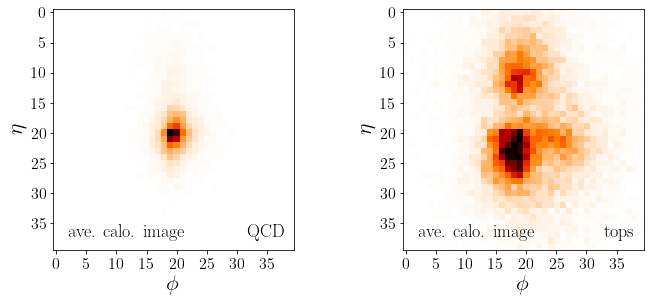

In [16]:
sg_ave = np.mean( data_sig, axis=0 ).reshape(40,40)
bg_ave = np.mean( data_bg, axis=0 ).reshape(40,40)

fig, axs = plt.subplots( 1, 2, figsize=(10,4.3) )

cmap = 'gist_heat_r'

axs[0].imshow( bg_ave, cmap=cmap )

axs[0].set_yticks(range(0,40,5))
axs[0].set_yticklabels(range(0,40,5), fontproperties=tickfont )

axs[0].set_xticks(range(0,40,5))
axs[0].set_xticklabels(range(0,40,5), fontproperties=tickfont )

axs[0].set_xlabel("$\phi$", fontproperties=axislabelfont)
axs[0].set_ylabel("$\eta$", fontproperties=axislabelfont)

axs[0].text( 2, 38,  "ave. calo. image", va='bottom', ha='left', fontproperties=labelfont2 )
axs[0].text( 38, 38,  "QCD", va='bottom', ha='right', fontproperties=labelfont2 )

axs[1].imshow( sg_ave, cmap=cmap )

axs[1].set_yticks(range(0,40,5))
axs[1].set_yticklabels(range(0,40,5), fontproperties=tickfont )

axs[1].set_xticks(range(0,40,5))
axs[1].set_xticklabels(range(0,40,5), fontproperties=tickfont )

axs[1].set_xlabel("$\phi$", fontproperties=axislabelfont)
axs[1].set_ylabel("$\eta$", fontproperties=axislabelfont)

axs[1].text( 2, 38,  "ave. calo. image", va='bottom', ha='left', fontproperties=labelfont2 )
axs[1].text( 38, 38,  "tops", va='bottom', ha='right', fontproperties=labelfont2 )

fig.tight_layout()

### Training stats <a class="anchor" id="trainingstats"></a>

We can check that the network has converged by plotting the statistics monitored during training.

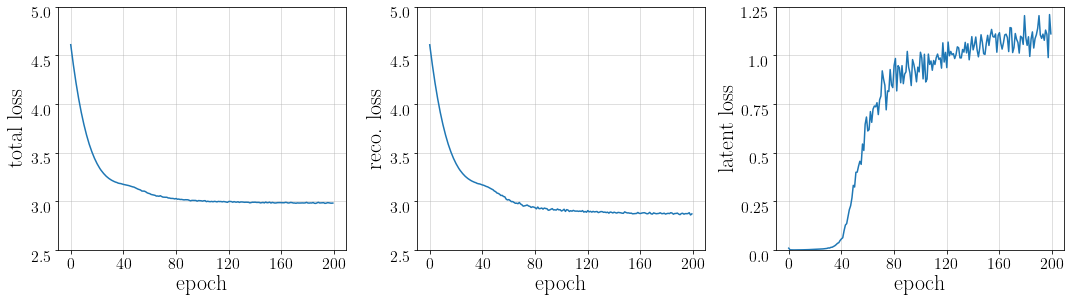

In [17]:
fig, axs = plt.subplots( 1, 3, figsize=(15,4.3) )

axs[0].plot( epoch_losses )
axs[0].grid( which='both', alpha=0.5 )
axs[0].set_xticks( [i*40 for i in range(6)] )
axs[0].set_xticklabels( [i*40 for i in range(6)], fontproperties=tickfont )
axs[0].set_ylim( (2.5,5) )
axs[0].set_yticks( [2.5+i*0.5 for i in range(6)] )
axs[0].set_yticklabels( [2.5+i*0.5 for i in range(6)] , fontproperties=tickfont, va='top' )
axs[0].set_xlabel( "epoch", fontproperties=axislabelfont )
axs[0].set_ylabel( "total loss", rotation="vertical", fontproperties=axislabelfont )

axs[1].plot( epoch_reco_losses )
axs[1].grid( which='both', alpha=0.5 )
axs[1].set_xticks( [i*40 for i in range(6)] )
axs[1].set_xticklabels( [i*40 for i in range(6)], fontproperties=tickfont )
axs[1].set_ylim( (2.5,5) )
axs[1].set_yticks( [2.5+i*0.5 for i in range(6)] )
axs[1].set_yticklabels( [2.5+i*0.5 for i in range(6)] , fontproperties=tickfont, va='top' )
axs[1].set_xlabel( "epoch", fontproperties=axislabelfont )
axs[1].set_ylabel( "reco. loss", rotation="vertical", fontproperties=axislabelfont )

axs[2].plot( epoch_latent_losses )
axs[2].grid( which='both', alpha=0.5 )
axs[2].set_xticks( [i*40 for i in range(6)] )
axs[2].set_xticklabels( [i*40 for i in range(6)], fontproperties=tickfont )
axs[2].set_ylim( (0.0,1.25) )
axs[2].set_yticks( [i*0.25 for i in range(6)] )
axs[2].set_yticklabels( [i*0.25 for i in range(6)] , fontproperties=tickfont, va='top' )
axs[2].set_xlabel( "epoch", fontproperties=axislabelfont )
axs[2].set_ylabel( "latent loss", rotation="vertical", fontproperties=axislabelfont )

fig.tight_layout()

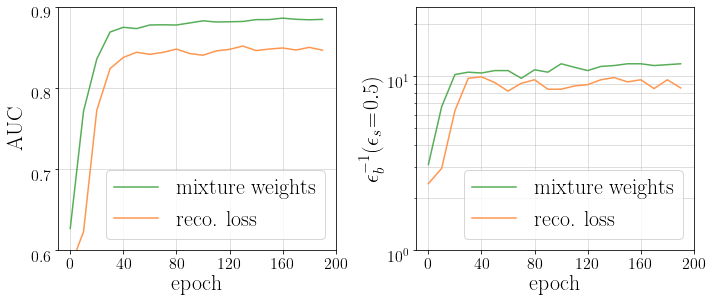

In [18]:
fig, axs = plt.subplots( 1, 2, figsize=(10,4.3) )

axs[0].plot( epoch_tw_aucs, label="mixture weights", color="xkcd:dark pastel green" )
axs[0].plot( epoch_rl_aucs, label="reco. loss", color="xkcd:pastel orange" )
axs[0].grid( which='both', alpha=0.5 )
axs[0].set_xticks( [i*4 for i in range(6)] )
axs[0].set_xticklabels( [i*40 for i in range(6)], fontproperties=tickfont )
axs[0].set_ylim( (0.6,0.9) )
axs[0].set_yticks( [0.6,0.7,0.8,0.9] )
axs[0].set_yticklabels( [0.6,0.7,0.8,0.9] , fontproperties=tickfont, va='top' )
axs[0].set_xlabel( "epoch", fontproperties=axislabelfont )
axs[0].set_ylabel( "AUC", rotation="vertical", fontproperties=axislabelfont )
axs[0].legend( loc='best', prop=axislabelfont )

axs[1].plot( epoch_tw_imtafes, label="mixture weights", color="xkcd:dark pastel green" )
axs[1].plot( epoch_rl_imtafes, label="reco. loss", color="xkcd:pastel orange" )
axs[1].grid( which='both', alpha=0.5 )
axs[1].set_xticks( [i*4 for i in range(6)] )
axs[1].set_xticklabels( [i*40 for i in range(6)], fontproperties=tickfont )
axs[1].set_ylim((1,25))
axs[1].set_yticks( [1,10] )
axs[1].set_yticklabels( [ "$10^{}$".format(i) for i in [0,1] ] , fontproperties=tickfont, va='top' )
axs[1].set_xlabel("epoch", fontproperties=axislabelfont )
axs[1].set_ylabel("$\\epsilon_b^{-1}(\\epsilon_s\!=\!0.5)$", rotation="vertical", fontproperties=axislabelfont )
axs[1].set_yscale('log')
axs[1].legend( loc='best', prop=axislabelfont )

fig.tight_layout()

### Latent space distributions <a class="anchor" id="latentspacedistributions"></a>

Here we show how the jets are separated in latent space.

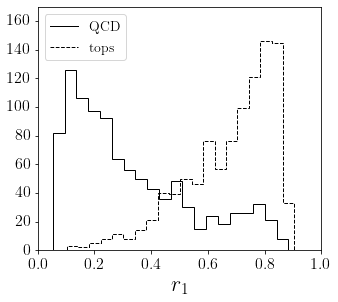

In [24]:
fig, axs = plt.subplots( 1, 1, figsize=(4.8,4.3) )

#labels = [ int(i) for i in labels ]

axs.hist( np.array( [ i.numpy() for i in tf.nn.softmax( final_zmeans )[:,0] ] )[labels==0], 
         alpha=1.0, bins=20, edgecolor="black", fill=None, histtype='stepfilled', 
         linestyle='solid', linewidth=1)
axs.hist( np.array( [ i.numpy() for i in tf.nn.softmax( final_zmeans )[:,0] ] )[labels==1], 
         alpha=1.0, bins=20, edgecolor="black", fill=None, histtype='stepfilled', 
         linestyle='dashed', linewidth=1)

#axs.text( 0.5, 0.85*yr[1],  "ep. 200", va='bottom', ha='center', fontproperties=tickfont )

custom_lines = [Line2D([0], [0], color='black', lw=1.0, ls='solid'),
                Line2D([0], [0], color='black', lw=1.0, ls='dashed')]

axs.legend( custom_lines, ['QCD', 'tops'], loc='upper left', prop=labelfont )

axs.set_xticks( [ i*0.2 for i in range(6) ] )
axs.set_xticklabels( [ np.round(i*0.2,1) for i in range(6)], fontproperties=tickfont, ha='center' )
axs.set_ylim( (0,170) )
axs.set_yticks( [ i*20 for i in range(9) ] )
axs.set_yticklabels( [ i*20 for i in range(9) ] , fontproperties=tickfont, va='center' )


fig.subplots_adjust(wspace=0.0,  
                    hspace=0.0) 
    
axs.set_xlabel("$r_1$", fontproperties=axislabelfont )

fig.tight_layout()

### ROC curves <a class="anchor" id="roccurves"></a>

<ipython-input-25-bfa31391e7e5>:3: RuntimeWarning: divide by zero encountered in true_divide
  axs.plot( tpr_z[0], np.nan_to_num(1/fpr_z[0]), alpha=1.0, color="xkcd:dark pastel green", linewidth=1.5, label="mixture weights, AUC: "+str(format(np.round(auc_z[0],2), '.2f')) )
<ipython-input-25-bfa31391e7e5>:4: RuntimeWarning: divide by zero encountered in true_divide
  axs.plot( tpr_r[0], np.nan_to_num(1/fpr_r[0]), alpha=1.0, color="xkcd:pastel orange", linewidth=1.5, label="reco. loss, AUC: "+str(format(np.round(auc_r[0],2), '.2f')) )
/Library/Python/3.8/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


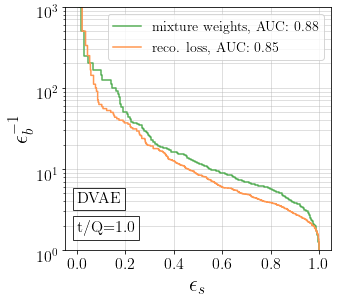

In [25]:
fig, axs = plt.subplots( 1, 1, figsize=(4.8,4.3) )

axs.plot( tpr_z[0], np.nan_to_num(1/fpr_z[0]), alpha=1.0, color="xkcd:dark pastel green", linewidth=1.5, label="mixture weights, AUC: "+str(format(np.round(auc_z[0],2), '.2f')) )
axs.plot( tpr_r[0], np.nan_to_num(1/fpr_r[0]), alpha=1.0, color="xkcd:pastel orange", linewidth=1.5, label="reco. loss, AUC: "+str(format(np.round(auc_r[0],2), '.2f')) )

axs.grid( which='both', alpha=0.5 )
    
axs.set_xlabel("$\epsilon_s$", fontproperties=axislabelfont )
axs.set_ylabel("$\epsilon_b^{-1}$", fontproperties=axislabelfont )

axs.set_yscale('log')

axs.set_xticks([np.round(i*0.2,1) for i in range(6)])
axs.set_xticklabels([np.round(i*0.2,1) for i in range(6)], fontproperties=tickfont )

axs.set_ylim((1,1000))

axs.set_yticks( [1,10,100,1000] )
axs.set_yticklabels( [ "$10^{}$".format(i) for i in [0,1,2,3] ] , fontproperties=tickfont, va='top' )

axs.legend( loc="upper right", prop=labelfont )

#axs.text( 0.0, 3.0,  "t/Q="+str(sb), va='bottom', ha='left', fontproperties=tickfont, bbox=dict(facecolor='white', alpha=0.8) )
axs.text( 0.0, 1.5,  "t/Q=1.0", va='bottom', ha='left', fontproperties=tickfont, bbox=dict(facecolor='white', alpha=0.8) )
axs.text( 0.0, 3.5,  "DVAE", va='bottom', ha='left', fontproperties=tickfont, bbox=dict(facecolor='white', alpha=0.8) )

fig.tight_layout()

### Decoder weights / mixture distributions <a class="anchor" id="decoderweights"></a>

Here we plot the visualisation of the decoder weights, allowing us to directly interpret what the network has learned.

<ipython-input-26-72495934a412>:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


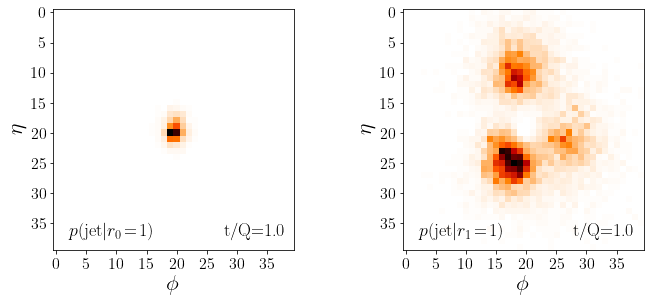

In [26]:
imgs_all = []
for tps in topics:
    imgs_all.append( [tps[0].reshape((40,40)), tps[1].reshape((40,40))]  )

fig, axs = plt.subplots( 1, 2, figsize=(10,4.3) )

cmap = 'gist_heat_r'

axs[0].imshow( imgs_all[-1][1], cmap=cmap )

axs[0].set_yticks(range(0,40,5))
axs[0].set_yticklabels(range(0,40,5), fontproperties=tickfont )

axs[0].set_xticks(range(0,40,5))
axs[0].set_xticklabels(range(0,40,5), fontproperties=tickfont )

axs[0].set_xlabel("$\phi$", fontproperties=axislabelfont)
axs[0].set_ylabel("$\eta$", fontproperties=axislabelfont)

axs[0].text( 2, 38,  "$p($jet$|r_0\!=\!1)$", va='bottom', ha='left', fontproperties=labelfont2 )
axs[0].text( 38, 38,  "t/Q=1.0", va='bottom', ha='right', fontproperties=labelfont2 )

axs[1].imshow( imgs_all[-1][0], cmap=cmap )

axs[1].set_yticks(range(0,40,5))
axs[1].set_yticklabels(range(0,40,5), fontproperties=tickfont )

axs[1].set_xticks(range(0,40,5))
axs[1].set_xticklabels(range(0,40,5), fontproperties=tickfont )

axs[1].set_xlabel("$\phi$", fontproperties=axislabelfont)
axs[1].set_ylabel("$\eta$", fontproperties=axislabelfont)

axs[1].text( 2, 38,  "$p($jet$|r_1\!=\!1)$", va='bottom', ha='left', fontproperties=labelfont2 )
axs[1].text( 38, 38,  "t/Q=1.0", va='bottom', ha='right', fontproperties=labelfont2 )

fig.tight_layout()

fig.show()